In [1]:
from utils import sample_utils as su, parse_midas_data, substitution_rates_utils, config, temporal_changes_utils, snps_utils
import numpy as np
from numpy.random import choice
from collections import defaultdict
import pickle
import sys
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy

plot_dir = "%s/snp_prevs/" % (config.analysis_directory)

In [2]:
ddir = config.data_directory
pdir = "%s/pickles" % ddir
sweep_type = 'full'
prev_distribution = pickle.load(open('%s/prev_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))

In [ ]:
prev_distribution

In [3]:
dNdS_distribution = pickle.load(open('%s/dNdS_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))

In [4]:
ddir = config.data_directory
pdir = "%s/pickles" % ddir
sweep_type = 'full'
prev_distribution_v2 = pickle.load(open('%s/prev_distribution_v2_%s.pkl' % (pdir, sweep_type), 'rb'))
dNdS_prev_distribution = pickle.load(open('%s/dNdS_prev_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))
null_prev_distribution = pickle.load(open('%s/null_prev_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))

In [5]:
derived_freq_bins = numpy.array([-1,0,0.01,0.1,0.5,0.9,0.99,2]) # changed 1,2 to just 2
derived_virtual_freqs = numpy.arange(0,len(derived_freq_bins)-1)
derived_freq_labels = ['0', '.01', '.1', '.5', '.9', '.99', '1']
def get_f_idx(f):
    return ((f>derived_freq_bins[:-1])*
            (f<=derived_freq_bins[1:])).argmax()

In [6]:
derived_freq_bins = numpy.array([-1,0,0.01,0.1,0.5,0.9,0.99,1, 2])
derived_virtual_freqs = numpy.arange(0,len(derived_freq_bins)-1)
derived_freq_labels = ['0', '.01', '.1', '.5', '.9', '.99', '1', '2']
def get_f_idx(f):
    return ((f>derived_freq_bins[:-1])*
            (f<=derived_freq_bins[1:])).argmax()

In [7]:
def tp_pair_to_tp_type(tp_pair):
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    return tp_type

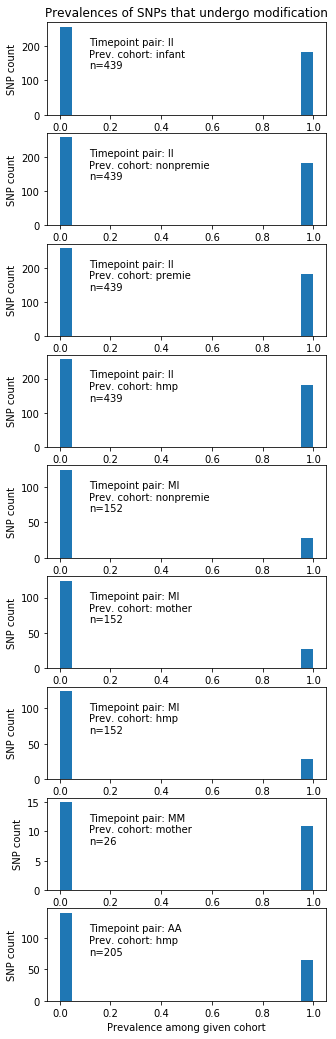

In [8]:
# start with simple histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

num_plots = 9
fig, ax = plt.subplots(num_plots, 1, figsize=(5,18))

i=0
event_type = 'modification'

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MI', 'nonpremie'), ('MI', 'mother'), ('MI', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    
    result = []
    
    pdict = prev_distribution[prev_cohort][event_type]
    for species in pdict:
        for cohort in pdict[species]:
            for tp_pair in pdict[species][cohort]:
                xtp_type = tp_pair_to_tp_type(tp_pair)
                if xtp_type != tp_type:
                    continue
                for fs_dict in pdict[species][cohort][tp_pair]:
                    result += fs_dict['4D']
                    result += fs_dict['1D']
    
    result = np.array(result)
    # chop off everything to [0, 1]
    result[result<0] = 0
    result[result>1] = 1
    # ax[i].set_yscale('log')
    # ax[i].axhline(y=10,color='red')
    ax[i].hist(result, bins=20)
    ax[i].set_ylabel("SNP count")
    ax[i].text(0.15, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, len(result)), transform=ax[i].transAxes)
    
    
    i += 1

ax[0].set_title("Prevalences of SNPs that undergo modification")
ax[num_plots-1].set_xlabel("Prevalence among given cohort")

plt.show()
fig.savefig('%s/modification_snp_prevs_%s.pdf' % (plot_dir, sweep_type))

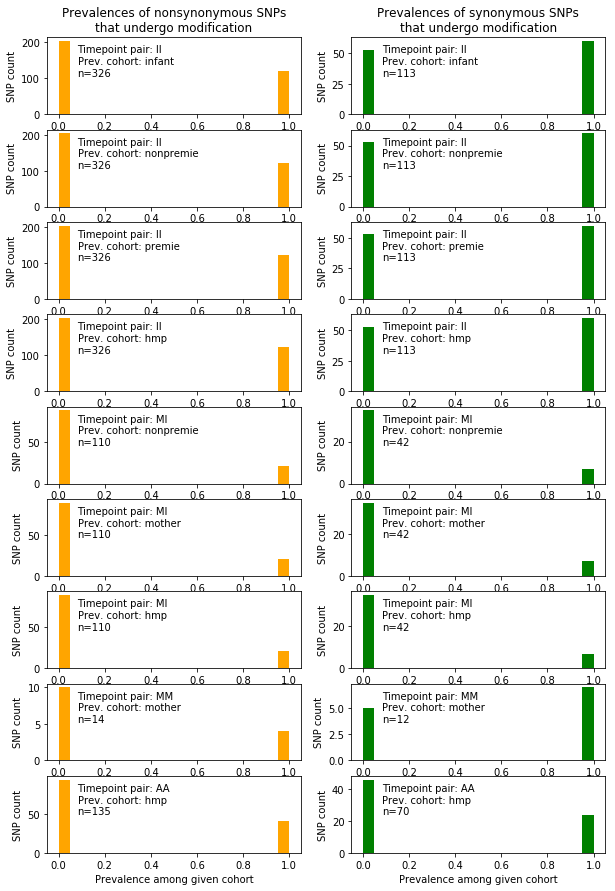

In [9]:
# now split up by nonsynonymous vs synonymous sites

num_plots = 9
fig, ax = plt.subplots(num_plots, 2, figsize=(10,15))

i=0
event_type = 'modification'
variant_types = ['1D', '4D']
colors = ['orange', 'green']

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MI', 'nonpremie'), ('MI', 'mother'), ('MI', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    for var_i in range(len(variant_types)):
        variant_type = variant_types[var_i]
        result = []

        pdict = prev_distribution[prev_cohort][event_type]
        for species in pdict:
            for cohort in pdict[species]:
                for tp_pair in pdict[species][cohort]:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for fs_dict in pdict[species][cohort][tp_pair]:
                        result += fs_dict[variant_type]

        result = np.array(result)
        # chop off everything to [0, 1]
        result[result<0] = 0
        result[result>1] = 1
        # ax[i][var_i].set_yscale('log')
        # ax[i][var_i].axhline(y=10,color='red')
        ax[i][var_i].hist(result, bins=20, color=colors[var_i])
        ax[i][var_i].set_ylabel("SNP count")
        ax[i][var_i].text(0.12, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, len(result)), transform=ax[i][var_i].transAxes)
    i += 1

ax[0][0].set_title("Prevalences of nonsynonymous SNPs\nthat undergo modification")
ax[0][1].set_title("Prevalences of synonymous SNPs\nthat undergo modification")
ax[num_plots-1][0].set_xlabel("Prevalence among given cohort")
ax[num_plots-1][1].set_xlabel("Prevalence among given cohort")

plt.show()
fig.savefig('%s/modification_snp_prevs_split_%s.pdf' % (plot_dir, sweep_type))

In [10]:
# nonsynonymous vs synonymous sites, tabular form

num_plots = 6
fig, ax = plt.subplots(num_plots, 2, figsize=(10,10))

i=0
event_type = 'modification'
variant_types = ['1D', '4D']

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    for var_i in range(len(variant_types)):
        variant_type = variant_types[var_i]
        result = []

        pdict = prev_distribution[prev_cohort][event_type]
        for species in pdict:
            for cohort in pdict[species]:
                for tp_pair in pdict[species][cohort]:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for fs_dict in pdict[species][cohort][tp_pair]:
                        result += fs_dict[variant_type]

        result = np.array(result)
        # chop off everything to [0, 1]
        result[result<0] = 0
        result[result>1] = 1
        num_rare = sum(result<0.05)
        num_total = len(result)
        prop_rare = float(num_rare)/num_total
        print("%s,%s,%s: %.04f" % (tp_type, variant_type, prev_cohort, prop_rare))
    i += 1

II,1D,infant: 0.6258
II,4D,infant: 0.4690
II,1D,nonpremie: 0.6258
II,4D,nonpremie: 0.4690
II,1D,premie: 0.6258
II,4D,premie: 0.4690
II,1D,hmp: 0.6258
II,4D,hmp: 0.4690
MM,1D,mother: 0.7143
MM,4D,mother: 0.4167
AA,1D,hmp: 0.6963
AA,4D,hmp: 0.6571


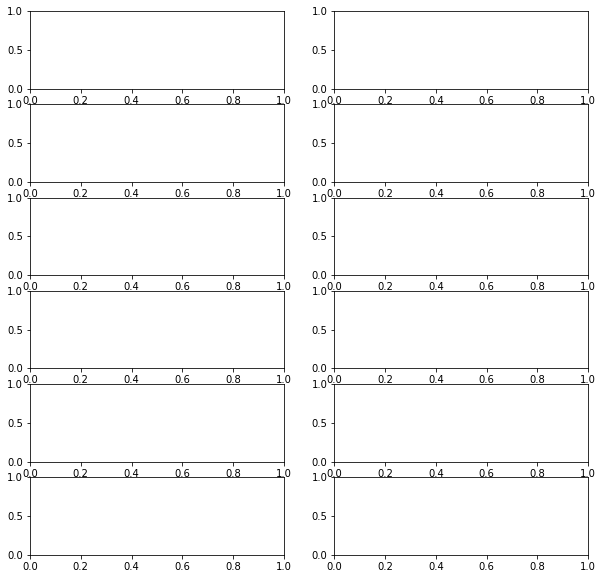

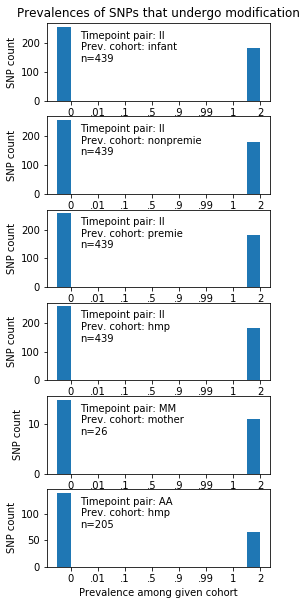

In [11]:
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

num_plots = 6
fig, ax = plt.subplots(num_plots, 1, figsize=(4,10))

i=0
event_type = 'modification'

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    
    bin_counts = np.zeros(len(derived_virtual_freqs))
    
    pdict = prev_distribution[prev_cohort][event_type]
    for species in pdict:
        for cohort in pdict[species]:
            for tp_pair in pdict[species][cohort]:
                xtp_type = tp_pair_to_tp_type(tp_pair)
                if xtp_type != tp_type:
                    continue
                for fs_dict in pdict[species][cohort][tp_pair]:
                    for f in fs_dict['4D']:
                        bin_counts[get_f_idx(f)] += 1
                    for f in fs_dict['1D']:
                        bin_counts[get_f_idx(f)] += 1
    
    ax[i].bar(derived_virtual_freqs, bin_counts, width=-0.5, align='edge')
    ax[i].set_xticks(derived_virtual_freqs)
    ax[i].set_xticklabels(derived_freq_labels)
    ax[i].set_ylabel("SNP count")
    ax[i].text(0.15, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, sum(bin_counts)), transform=ax[i].transAxes)
    
    
    i += 1

ax[0].set_title("Prevalences of SNPs that undergo modification")
ax[num_plots-1].set_xlabel("Prevalence among given cohort")

plt.show()
# fig.savefig('%s/modification_snp_prevs_%s.pdf' % (plot_dir, sweep_type))

In [12]:
snv_freq_map = {}
for prev_cohort in prev_cohorts:
snv_freq_map[prev_cohort] = snps_utils.parse_population_freqs(prev_cohort, species_name, polarize_by_consensus=True)

IndentationError: expected an indented block (<ipython-input-12-ca54e3fd0e85>, line 3)

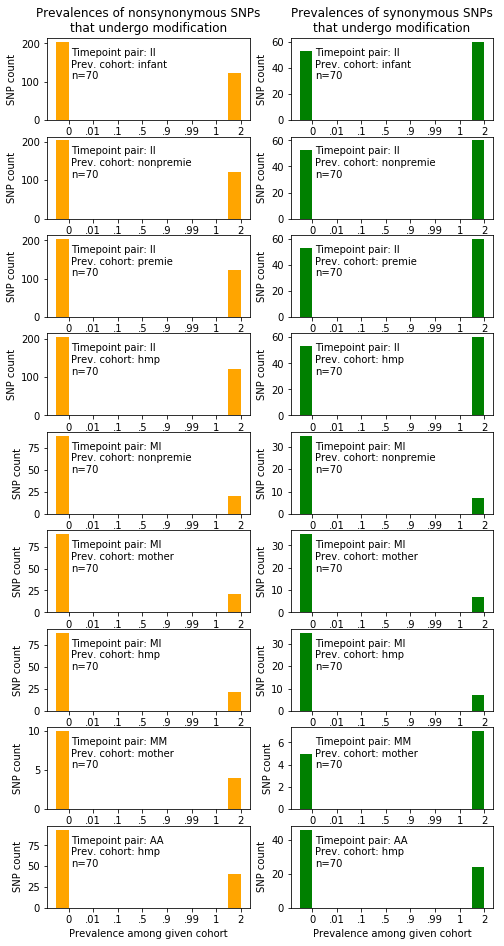

In [13]:
# now split up by nonsynonymous vs synonymous sites

num_plots = 9
fig, ax = plt.subplots(num_plots, 2, figsize=(8,16))

i=0
event_type = 'modification'
variant_types = ['1D', '4D']
colors = ['orange', 'green']

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MI', 'nonpremie'), ('MI', 'mother'), ('MI', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    for var_i in range(len(variant_types)):
        variant_type = variant_types[var_i]
        
        bin_counts = np.zeros(len(derived_virtual_freqs))
    
        pdict = prev_distribution[prev_cohort][event_type]
        for species in pdict:
            for cohort in pdict[species]:
                for tp_pair in pdict[species][cohort]:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for fs_dict in pdict[species][cohort][tp_pair]:
                        for f in fs_dict[variant_type]:
                            bin_counts[get_f_idx(f)] += 1

        ax[i][var_i].bar(derived_virtual_freqs, bin_counts, width=-0.5, align='edge', color=colors[var_i])
        ax[i][var_i].set_xticks(derived_virtual_freqs)
        ax[i][var_i].set_xticklabels(derived_freq_labels)
        ax[i][var_i].set_ylabel("SNP count")
        ax[i][var_i].text(0.12, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, len(result)), transform=ax[i][var_i].transAxes)
    i += 1

ax[0][0].set_title("Prevalences of nonsynonymous SNPs\nthat undergo modification")
ax[0][1].set_title("Prevalences of synonymous SNPs\nthat undergo modification")
ax[num_plots-1][0].set_xlabel("Prevalence among given cohort")
ax[num_plots-1][1].set_xlabel("Prevalence among given cohort")

plt.show()
fig.savefig('%s/modification_snp_prevs_split_%s.pdf' % (plot_dir, sweep_type))

In [4]:
# the whole shebang
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

num_plots = 6
fig, ax = plt.subplots(num_plots, 1, figsize=(6,20))
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    
    cum_bin_counts = np.zeros(len(derived_virtual_freqs))
    
    nonsyn_count = np.zeros(len(derived_virtual_freqs))
    syn_count = np.zeros(len(derived_virtual_freqs))
    
    for variant_type in ['4D', '1D', '2D', '3D']:
        
        bin_counts = np.zeros(len(derived_virtual_freqs))
        pdict = prev_distribution[prev_cohort][event_type]
        
        for species in pdict:
            for cohort in pdict[species]:
                for tp_pair in pdict[species][cohort]:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for fs_dict in pdict[species][cohort][tp_pair]:
                        for f in fs_dict[variant_type]:
                            f_idx = get_f_idx(f)
                            bin_counts[f_idx] += 1
                            if variant_type == '4D':
                                syn_count[f_idx] += 1
                            if variant_type == '1D':
                                nonsyn_count[f_idx] += 1
        
        ax[i].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=-0.5, align='edge', color=colors[variant_type])
        cum_bin_counts += bin_counts
    
    for j in derived_virtual_freqs:
            dNdS = nonsyn_count[j]/float(syn_count[j])
            ax[i].text(j-0.5, cum_bin_counts[j] + (max(cum_bin_counts)*0.04), '%.03f' % dNdS, color='blue')
    
    ax[i].set_xticks(derived_virtual_freqs)
    ax[i].set_xticklabels(derived_freq_labels)
    ax[i].set_ylabel("SNP count")
    ax[i].text(0.15, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, sum(cum_bin_counts)), transform=ax[i].transAxes)
           
    i += 1

ax[0].set_title("Prevalences of SNPs that undergo modification")
ax[num_plots-1].set_xlabel("Prevalence among given cohort")

plt.show()
# fig.savefig('%s/modification_snp_prevs_%s.pdf' % (plot_dir, sweep_type))

NameError: name 'prev_distribution' is not defined

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars


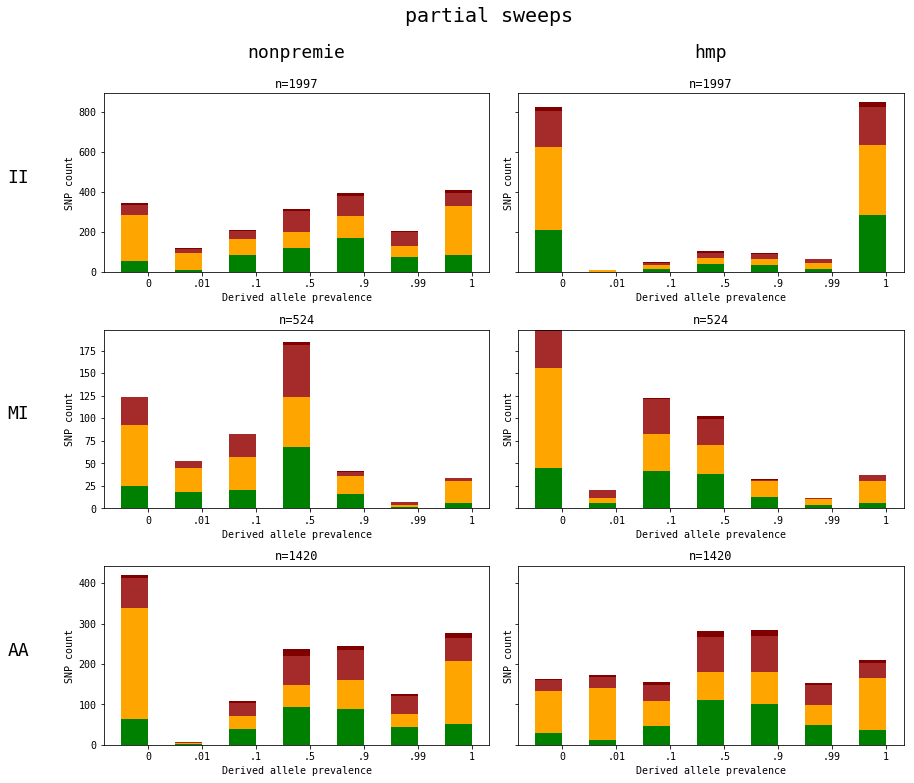

In [9]:
# the whole shebang (format 2)
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

from matplotlib import rcParams
rcParams['font.family'] = 'monospace'

fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharey='row')
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:    
        
        cum_bin_counts = np.zeros(len(derived_virtual_freqs))
        
        nonsyn_count = np.zeros(len(derived_virtual_freqs))
        syn_count = np.zeros(len(derived_virtual_freqs))
        
        for variant_type in ['4D', '1D', '2D', '3D']:

            bin_counts = np.zeros(len(derived_virtual_freqs))
            pdict = prev_distribution[prev_cohort][event_type]

            for species in pdict:
                for cohort in pdict[species]:
                    for tp_pair in pdict[species][cohort]:
                        xtp_type = tp_pair_to_tp_type(tp_pair)
                        if xtp_type != tp_type:
                            continue
                        for fs_dict in pdict[species][cohort][tp_pair]:
                            for f in fs_dict[variant_type]:
                                f_idx = get_f_idx(f)
                                bin_counts[f_idx] += 1
                                if variant_type == '4D':
                                    syn_count[f_idx] += 1
                                if variant_type == '1D':
                                    nonsyn_count[f_idx] += 1

            ax[i][j].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=-0.5, align='edge', color=colors[variant_type])
            cum_bin_counts += bin_counts

        for k in derived_virtual_freqs:
                dNdS = nonsyn_count[k]/float(syn_count[k])
                # ax[i][j].text(j-0.5, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), '%.03f' % dNdS, color='blue')

        ax[i][j].set_xticks(derived_virtual_freqs)
        ax[i][j].set_xticklabels(derived_freq_labels)
        ax[i][j].set_ylabel("SNP count")
        ax[i][j].set_xlabel("Derived allele prevalence")
        ax[i][j].set_title("n=%i" % sum(cum_bin_counts))
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

ax[0][0].text(1.0, 1.4, "%s sweeps" % sweep_type, ha='center', fontsize=20, transform=ax[0][0].transAxes)

plt.tight_layout()
plt.show()
fig.savefig('%s/modification_snp_prevs_final_%s.pdf' % (plot_dir, sweep_type))

In [14]:
# the whole shebang (format 2)
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

from matplotlib import rcParams
rcParams['font.family'] = 'monospace'

fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharey='row')
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:    
        
        cum_bin_counts = np.zeros(len(derived_virtual_freqs))
        
        nonsyn_count = np.zeros(len(derived_virtual_freqs))
        syn_count = np.zeros(len(derived_virtual_freqs))
        
        dNdS_binned = { cat: np.zeros(len(derived_virtual_freqs)) for cat in ['dSnum', 'dSden', 'dNnum', 'dNden'] }
        
        for species in dNdS_prev_distribution[prev_cohort]:
            for cohort in dNdS_prev_distribution[prev_cohort][species]:
                subdict = dNdS_prev_distribution[prev_cohort][species][cohort]
                for tp_pair in subdict:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for cat in subdict[tp_pair]:                    
                        if not np.isnan(subdict[tp_pair][cat]).any(): # TODO: why does nan show up at all?
                            dNdS_binned[cat] += subdict[tp_pair][cat]
        
        for variant_type in ['4D', '1D', '2D', '3D']:

            bin_counts = np.zeros(len(derived_virtual_freqs))
            pdict = prev_distribution_v2[prev_cohort][event_type]

            for species in pdict:
                for cohort in pdict[species]:
                    for tp_pair in pdict[species][cohort]:
                        xtp_type = tp_pair_to_tp_type(tp_pair)
                        if xtp_type != tp_type:
                            continue
                        for fs_dict in pdict[species][cohort][tp_pair]:
                            for f in fs_dict[variant_type]:
                                f_idx = get_f_idx(f)
                                bin_counts[f_idx] += 1
                                if variant_type == '4D':
                                    syn_count[f_idx] += 1
                                if variant_type == '1D':
                                    nonsyn_count[f_idx] += 1

            ax[i][j].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=-0.5, align='edge', color=colors[variant_type])
            cum_bin_counts += bin_counts

        for k in derived_virtual_freqs:
                dS = dNdS_binned['dSnum'][k]/float(dNdS_binned['dSden'][k])
                dN = dNdS_binned['dNnum'][k]/float(dNdS_binned['dNden'][k])
                dNdS = dN/float(dS)
                ax[i][j].text(k-0.5, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), '%.03f' % dNdS, color='blue')

        ax[i][j].set_xticks(derived_virtual_freqs)
        ax[i][j].set_xticklabels(derived_freq_labels)
        ax[i][j].set_ylabel("SNP count")
        ax[i][j].set_xlabel("Derived allele prevalence")
        ax[i][j].set_title("n=%i" % sum(cum_bin_counts))
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

ax[0][0].text(1.0, 1.4, "%s sweeps" % sweep_type, ha='center', fontsize=20, transform=ax[0][0].transAxes)

plt.tight_layout()
plt.show()
fig.savefig('%s/modification_snp_prevs_with_dnds_%s.pdf' % (plot_dir, sweep_type))

ValueError: operands could not be broadcast together with shapes (8,) (7,) (8,) 

In [9]:
dNdS_prev_distribution['hmp']['Bacteroides_vulgatus_57955']['hmp'].keys()

[frozenset({'A2', 'A3'}), frozenset({'A1', 'A3'}), frozenset({'A1', 'A2'})]

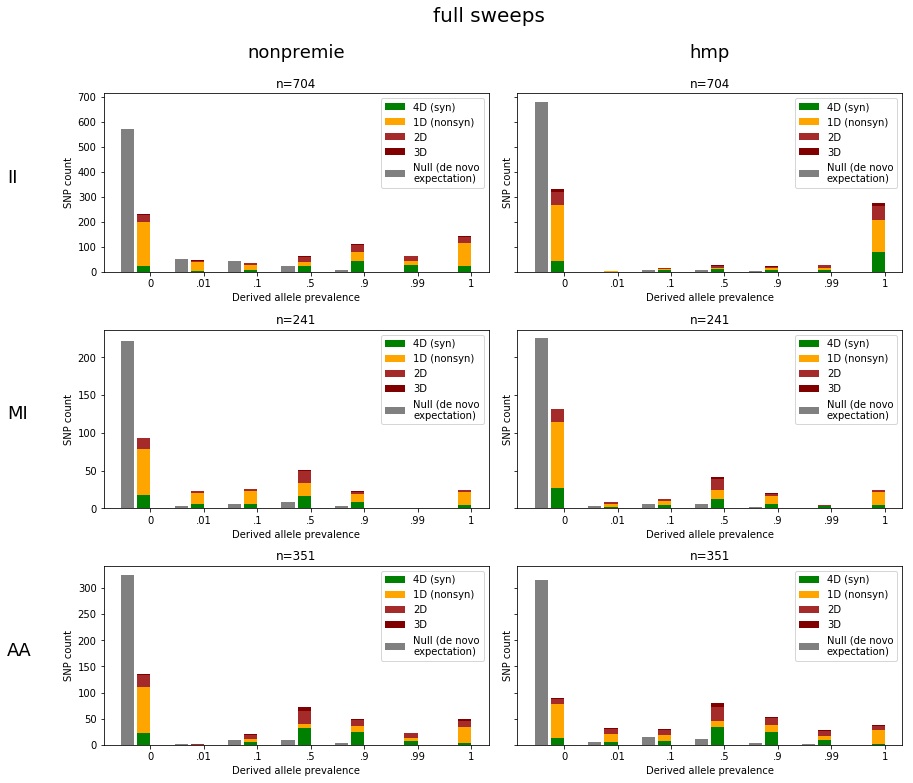

In [8]:
# With null bars
# the whole shebang (format 2)
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharey='row')
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']

variant_types = ['4D', '1D', '2D', '3D']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:    
        
        cum_bin_counts = np.zeros(len(derived_virtual_freqs))
        
        nonsyn_count = np.zeros(len(derived_virtual_freqs))
        syn_count = np.zeros(len(derived_virtual_freqs))
        '''
        dNdS_binned = { cat: np.zeros(len(derived_virtual_freqs)) for cat in ['dSnum', 'dSden', 'dNnum', 'dNden'] }
        
        for species in dNdS_prev_distribution[prev_cohort]:
            for cohort in dNdS_prev_distribution[prev_cohort][species]:
                subdict = dNdS_prev_distribution[prev_cohort][species][cohort]
                for cat in subdict:                    
                    if not np.isnan(subdict[cat]).any(): # TODO: why does nan show up at all?
                        dNdS_binned[cat] += subdict[cat]
        '''
        null_bin_counts = np.zeros(len(derived_virtual_freqs))
        # npdict = null_prev_distribution[prev_cohort][event_type]
        
        ndict = null_prev_distribution[prev_cohort][event_type]

        for species in ndict:
            for cohort in ndict[species]:
                if len(ndict[species][cohort].keys()) > 0:
                    for tp_pair in ndict[species][cohort]:
                        xtp_type = tp_pair_to_tp_type(tp_pair)
                        if xtp_type != tp_type:
                            continue
                        null_bin_counts += ndict[species][cohort][tp_pair]
        
        ax[i][j].bar(derived_virtual_freqs-0.3, null_bin_counts, width=-0.25, align='edge', color='gray')
                    
        for variant_type in variant_types:

            bin_counts = np.zeros(len(derived_virtual_freqs))
            pdict = prev_distribution_v2[prev_cohort][event_type]

            for species in pdict:
                for cohort in pdict[species]:
                    for tp_pair in pdict[species][cohort]:
                        xtp_type = tp_pair_to_tp_type(tp_pair)
                        if xtp_type != tp_type:
                            continue
                        for fs_dict in pdict[species][cohort][tp_pair]:
                            for f in fs_dict[variant_type]:
                                f_idx = get_f_idx(f)
                                bin_counts[f_idx] += 1
                                if variant_type == '4D':
                                    syn_count[f_idx] += 1
                                if variant_type == '1D':
                                    nonsyn_count[f_idx] += 1
            
            ax[i][j].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=-0.25, align='edge', color=colors[variant_type])
            cum_bin_counts += bin_counts
        '''
        for k in derived_virtual_freqs:
                dS = dNdS_binned['dSnum'][k]/float(dNdS_binned['dSden'][k])
                dN = dNdS_binned['dNnum'][k]/float(dNdS_binned['dNden'][k])
                dNdS = dN/float(dS)
                ax[i][j].text(k-0.5, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), '%.03f' % dNdS, color='blue')
        '''
        ax[i][j].set_xticks(derived_virtual_freqs)
        ax[i][j].set_xticklabels(derived_freq_labels)
        ax[i][j].set_ylabel("SNP count")
        ax[i][j].set_xlabel("Derived allele prevalence")
        ax[i][j].set_title("n=%i" % sum(cum_bin_counts))
        
        custom_patches = [Patch(facecolor=colors[variant_type]) for variant_type in variant_types]
        custom_patches += [Patch(facecolor='gray')]
        ax[i][j].legend(custom_patches, ['4D (syn)', '1D (nonsyn)', '2D', '3D', 'Null (de novo\nexpectation)'])
        
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

ax[0][0].text(1.0, 1.4, "%s sweeps" % sweep_type, ha='center', fontsize=20, transform=ax[0][0].transAxes)

plt.tight_layout()
plt.show()
fig.savefig('%s/modification_snp_prevs_final_%s.pdf' % (plot_dir, sweep_type), bbox_inches='tight')

In [25]:
ndict

{'Acidaminococcus_intestini_54097': {'backhed': {},
  'ferretti': {},
  'hmp': {},
  'olm': {},
  'shao': {},
  'yassour': {}},
 'Actinomyces_sp_62581': {'backhed': {},
  'ferretti': {},
  'hmp': {},
  'olm': {},
  'shao': {},
  'yassour': {}},
 'Actinomyces_urogenitalis_53864': {'backhed': {},
  'ferretti': {},
  'hmp': {},
  'olm': {},
  'shao': {},
  'yassour': {}},
 'Akkermansia_muciniphila_55290': {'backhed': {frozenset({'I3',
              'M1'}): array([0.9 , 0.  , 0.  , 0.08, 0.02, 0.  , 0.  ])},
  'ferretti': {},
  'hmp': {frozenset({'A1',
              'A2'}): array([6.49655172e+00, 0.00000000e+00, 2.89826830e-01, 1.29331800e-01,
          7.06682000e-02, 1.01731700e-02, 3.44828000e-03])},
  'olm': {},
  'shao': {},
  'yassour': {frozenset({'M2',
              'M3'}): array([0.99714286, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.00285714]),
   frozenset({'M1',
              'M2'}): array([2.69985507e+01, 9.92063490e-02, 5.65437710e-01, 9.91520400e

In [62]:
# investigate HMP weirdness
cum_bin_counts = np.zeros(len(derived_virtual_freqs))

pdict = prev_distribution['hmp']['modification']
tp_type = 'AA'
cohort = 'hmp'

for variant_type in ['4D', '1D', '2D', '3D']:

    bin_counts = np.zeros(len(derived_virtual_freqs))

    for species in pdict:
        for tp_pair in pdict[species][cohort]:
            xtp_type = tp_pair_to_tp_type(tp_pair)
            if xtp_type != tp_type:
                continue
            for fs_dict in pdict[species][cohort][tp_pair]:
                for f in fs_dict[variant_type]:
                    f_idx = get_f_idx(f)
                    bin_counts[f_idx] += 1

    print(variant_type)
    print(bin_counts)

4D
[ 28.  13.  46. 111. 100.  49.  36.]
1D
[106. 128.  62.  69.  79.  49. 130.]
2D
[26. 28. 41. 86. 91. 49. 36.]
3D
[ 2.  4.  7. 15. 13.  7.  9.]


In [59]:
syn_count

array([ 36456.,  16926.,  59892., 144522., 130200.,  63798.,  46872.])

In [ ]:
# the whole shebang
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves
# with corrected dN/dS values

num_plots = 6
fig, ax = plt.subplots(num_plots, 1, figsize=(6,20))
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_type_prev_cohorts = [('II', 'infant'), ('II', 'nonpremie'), ('II', 'premie'), ('II', 'hmp'), ('MM', 'mother'), ('AA', 'hmp')]
for tp_type, prev_cohort in tp_type_prev_cohorts:
    
    cum_bin_counts = np.zeros(len(derived_virtual_freqs))
    
    nonsyn_count = np.zeros(len(derived_virtual_freqs))
    syn_count = np.zeros(len(derived_virtual_freqs))
    
    for variant_type in ['4D', '1D', '2D', '3D']:
        
        bin_counts = np.zeros(len(derived_virtual_freqs))
        pdict = prev_distribution[prev_cohort][event_type]
        
        for species in pdict:
            for cohort in pdict[species]:
                for tp_pair in pdict[species][cohort]:
                    xtp_type = tp_pair_to_tp_type(tp_pair)
                    if xtp_type != tp_type:
                        continue
                    for fs_dict in pdict[species][cohort][tp_pair]:
                        for f in fs_dict[variant_type]:
                            f_idx = get_f_idx(f)
                            bin_counts[f_idx] += 1
                            if variant_type == '4D':
                                syn_count[f_idx] += 1
                            if variant_type == '1D':
                                nonsyn_count[f_idx] += 1
        
        ax[i].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=-0.5, align='edge', color=colors[variant_type])
        cum_bin_counts += bin_counts
    
    for j in derived_virtual_freqs:
            dNdS = nonsyn_count[j]/float(syn_count[j])
            ax[i].text(j-0.5, cum_bin_counts[j] + (max(cum_bin_counts)*0.04), '%.03f' % dNdS, color='blue')
    
    ax[i].set_xticks(derived_virtual_freqs)
    ax[i].set_xticklabels(derived_freq_labels)
    ax[i].set_ylabel("SNP count")
    ax[i].text(0.15, 0.5, "Timepoint pair: %s\nPrev. cohort: %s\nn=%i" % (tp_type, prev_cohort, sum(cum_bin_counts)), transform=ax[i].transAxes)
           
    i += 1

ax[0].set_title("Prevalences of SNPs that undergo modification")
ax[num_plots-1].set_xlabel("Prevalence among given cohort")

plt.show()
# fig.savefig('%s/modification_snp_prevs_%s.pdf' % (plot_dir, sweep_type))

In [37]:
ddir = config.data_directory
pdir = "%s/pickles" % ddir
sweep_type = 'partial'
dNdS_distribution = pickle.load(open('%s/dNdS_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))

In [38]:
# Recall what dNdS distribution is:
# looping over all QP pairs, consecutive timepoints

# Store its sdiffs/sopps/ndiffs/nopps
# aggregated only by subject.
# That is, if multiple subjects have the same
# timepoint pair, their dN/dS info will be
# grouped together.

dNdS_per_tp_pair = {}

ddict = dNdS_distribution['modification']

for species in ddict:
    for cohort in ddict[species]:
        for tp_pair in ddict[species][cohort]:
            sdiff, sopp, ndiff, nopp = ddict[species][cohort][tp_pair]
            if tp_pair not in dNdS_per_tp_pair:
                dNdS_per_tp_pair[tp_pair] = [0, 0, 0, 0]
            else:
                dNdS_per_tp_pair[tp_pair][0] += sdiff
                dNdS_per_tp_pair[tp_pair][1] += sopp
                dNdS_per_tp_pair[tp_pair][2] += ndiff
                dNdS_per_tp_pair[tp_pair][3] += nopp

In [39]:
strings = []

for tp_pair in dNdS_per_tp_pair:
    tpa, tpb = tp_pair
    if tpa > tpb:
        tpa_temp = tpa
        tpa = tpb
        tpb = tpa_temp
    sdiff, sopp, ndiff, nopp = dNdS_per_tp_pair[tp_pair]
    if sopp != 0 and nopp != 0:
        dNdS = (sdiff/float(sopp))/(ndiff/float(nopp))
        strings.append("%.04f: dNdS for %s -- %s" % (dNdS, tpa, tpb))

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
sorted(strings)

['0.0000: dNdS for I10 -- I13',
 '0.0000: dNdS for I15 -- I16',
 '0.0000: dNdS for I2 -- M2',
 '0.0000: dNdS for I3 -- M2',
 '0.0157: dNdS for I19 -- I20',
 '0.0537: dNdS for I4 -- M2',
 '0.1197: dNdS for I4 -- M3',
 '0.1399: dNdS for I21 -- I342.515',
 '0.1503: dNdS for M1 -- M2',
 '0.2176: dNdS for I4 -- M1',
 '0.3063: dNdS for I1 -- I2',
 '0.3541: dNdS for A1 -- A2',
 '0.3914: dNdS for I21 -- I7',
 '0.4286: dNdS for I3 -- M1',
 '0.4359: dNdS for I5 -- M2',
 '0.4647: dNdS for I3 -- I4',
 '0.7264: dNdS for I2 -- M1',
 '0.7770: dNdS for A1 -- A3',
 '1.3462: dNdS for A2 -- A3',
 '1.5556: dNdS for I2 -- I3',
 '3.8774: dNdS for I18 -- I19',
 'inf: dNdS for I1 -- I3',
 'inf: dNdS for I1 -- M1',
 'inf: dNdS for I24 -- I37',
 'inf: dNdS for I280.6 -- I7',
 'inf: dNdS for I4 -- I5',
 'inf: dNdS for I4 -- I7',
 'inf: dNdS for I5 -- M1',
 'inf: dNdS for I7 -- M1',
 'nan: dNdS for I17 -- I18',
 'nan: dNdS for I19 -- I21',
 'nan: dNdS for I2 -- I5',
 'nan: dNdS for I20 -- I24',
 'nan: dNdS for I2

In [ ]:
# Try plotting...?

for tp_pair in dNdS_per_tp_pair:
    tpa, tpb = tp_pair
    tpa_day = float(tpa[1:])
    tpb_day = float(tpb[1:])
    sdiff, sopp, ndiff, nopp = dNdS_per_tp_pair[tp_pair]
    if sopp != 0 and nopp != 0:
        dNdS = (sdiff/float(sopp))/(ndiff/float(nopp))
    print("dNdS for %s=>%s: %.04f" % (tpa, tpb, dNdS))